<a href="https://colab.research.google.com/github/imnotjohn/cityscience/blob/main/MAS_552_interactive_models_Apr_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Intebded Learning Outcomes
- learn to use interactive mapping tool unfolded.ai
- learn to create simple interactive widgets in Jupyter notebooks
- revisit density and proximity calculations from previous workshop
- create an interactive model for exploring urban interventions in Kendall

In [1]:
!pip install pandana
import pandana # for proximity analysis
!pip install osmnet
import osmnet # for downloading the OSM network data

import geopandas as gpd # for spatial operations
import numpy as np # for math
import urllib.request as ur # for downloading data
from gzip import GzipFile
import pandas as pd # for working with dataframes

# Using unfolded.ai for mapping

In [4]:
# !pip install 'unfolded.map_sdk>=0.6.3' sidecar
!pip install unfolded.map-sdk
# from unfolded.map_sdk import UnfoldedMap
from unfolded.map_sdk import create_map
from sidecar import Sidecar
from uuid import uuid4

If Jupyter asks you to restart the runtime, do so and rerun the cells above

In [5]:
# unfolded_map = UnfoldedMap()
unfolded_map = create_map()
# unfolded_map

sc = Sidecar(title='Unfolded Map', anchor='split-right')
with sc:
    display(unfolded_map)

SyncWidgetMap(style={'height': 500, 'width': '100%'})

In [7]:
# unfolded_map.set_view_state({
unfolded_map.set_view({
        'longitude': -71.082382,
        'latitude': 42.365680,
        'zoom': 13})



View(longitude=-71.082382, latitude=42.36568, zoom=13, pitch=0, bearing=0)

# Create a simple interactive model in Colab using widgets

### Import the required libraries

In [8]:
from ipywidgets import interact
#from ipywidgets import interactive, fixed, interact_manual
import ipywidgets as widgets

In [9]:
import matplotlib.pyplot as plt

In [10]:
def f(X, a, b):
    plt.scatter(range(X), [x*a+b for x in range(X)])

interactive(children=(IntSlider(value=10, description='X'), IntSlider(value=1, description='a'), IntSlider(val…

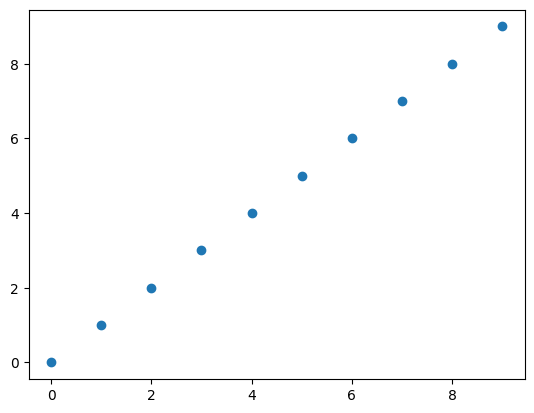

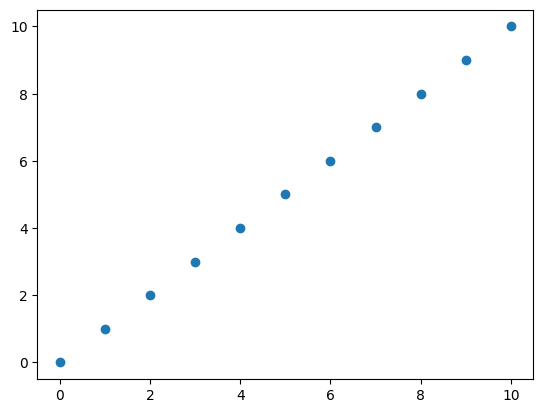

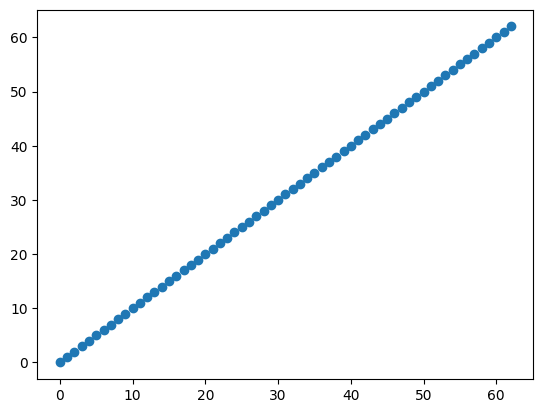

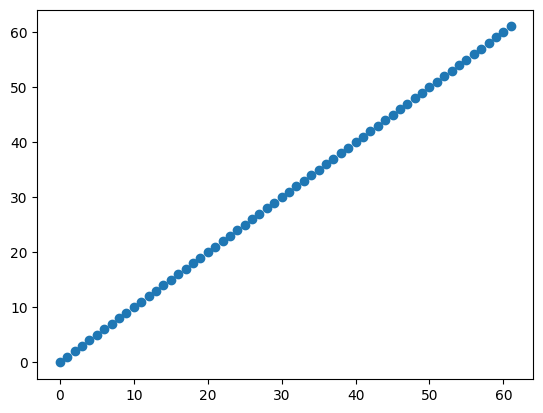

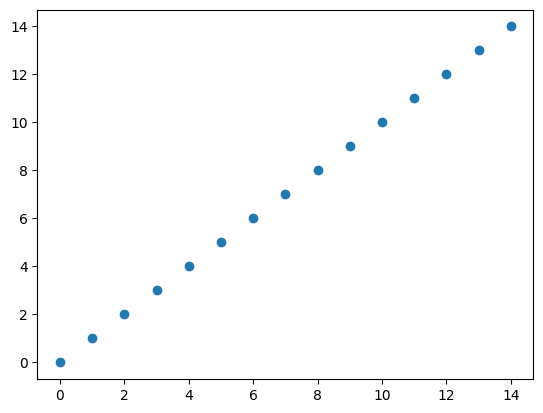

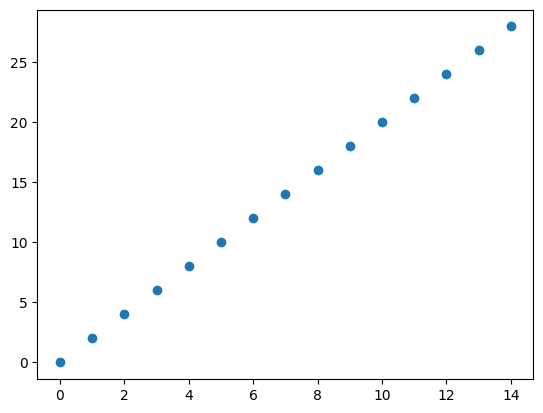

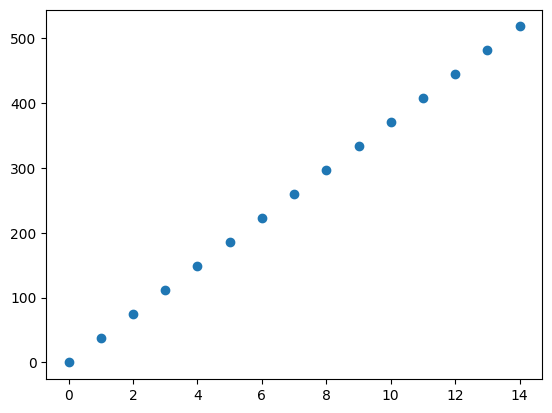

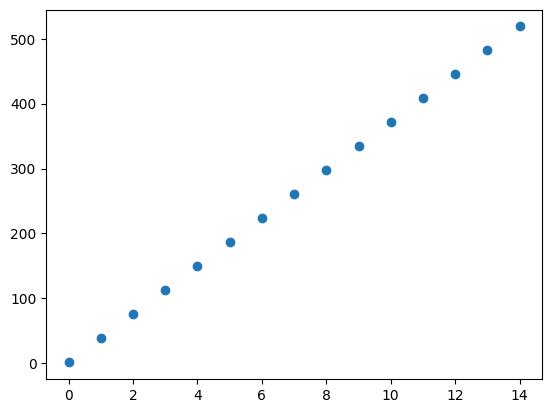

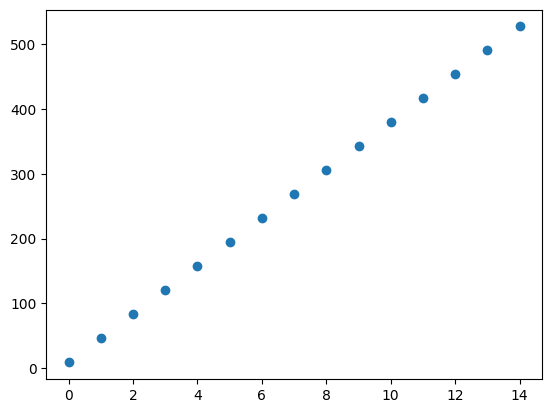

In [11]:
interact(f, X=widgets.IntSlider(min=0, max=100, step=1, value=10),
         a=widgets.IntSlider(min=0, max=100, step=1, value=1),
         b=widgets.IntSlider(min=0, max=50, step=1, value=0));

## Exercise: create a new interacive model which will multiply any two numbers, a and b, and print the answer

# Set up the context for an interactive urban model


## Baseline Data
Use the same process the previous python workshop to get the block group geometries and residence and workplace data from LODES
- download block group geometry data
- subset by bounding box of study area
- get RAC and WAC data by block-group from LODES
- join the RAC and WAC data to the geometry data

In [ ]:
def get_geometry(state_fips, geom_type, year, target_crs="EPSG:4326"):
    print('Getting geometry ({}) for state: {}'.format(geom_type, state_fips))
    geom_type_map={'block_group': ['BG', 'bg'], 'tract': ['TRACT', 'tract'], 'block': ['TABBLOCK', 'tabblock10']}
    try:
        geom_type_l=geom_type_map[geom_type]
    except:
        print('Unrecognised geometry :'+geom_type)
    geom=gpd.read_file('https://www2.census.gov/geo/tiger/TIGER{}/{}/tl_{}_{}_{}.zip'.format(
                year, geom_type_l[0], year, state_fips, geom_type_l[1]))
    geoid_col=[col for col in geom.columns if 'GEOID' in col][0]
    geom=geom.rename(columns={geoid_col: 'GEOID'})
    geom=geom.set_index('GEOID')
    geom=geom.to_crs(target_crs)
    geom.index=[int(i) for i in geom.index]
    return geom

def get_rac_data(state_abbr, year):
    print('Getting RAC data from https://lehd.ces.census.gov/data/lodes/LODES7/')
    req = ur.Request('https://lehd.ces.census.gov/data/lodes/LODES7/{}/rac/{}_rac_S000_JT00_{}.csv.gz'.format(
            state_abbr, state_abbr, year))
    z_f = ur.urlopen(req)
    f = GzipFile(fileobj=z_f, mode="r")
    rac = pd.read_csv(f)
    return rac

def get_wac_data(state_abbr, year):
    print('Getting WAC data from https://lehd.ces.census.gov/data/lodes/LODES7/')
    req = ur.Request('https://lehd.ces.census.gov/data/lodes/LODES7/{}/wac/{}_wac_S000_JT00_{}.csv.gz'.format(
            state_abbr, state_abbr, year))
    z_f = ur.urlopen(req)
    f = GzipFile(fileobj=z_f, mode="r")
    wac = pd.read_csv(f)
    return wac

def lodes_block_to_bg(block_data):
    block_cols=[col for col in ['h_geocode', 'w_geocode'] if col in block_data.columns]
    cols_to_agg=[col for col in block_data.columns if not col in [
      'w_geocode', 'h_geocode', 'w_geoid', 'h_geoid', 'createdate']]
    for col in block_cols:
      block_data[col.replace('geocode', 'geoid')]=block_data[col].floordiv(1000)
    bg_cols=[col.replace('geocode', 'geoid') for col in block_cols]
    bg_data=block_data.groupby(bg_cols, as_index=False)[cols_to_agg].sum()
    return bg_data

lat_min=42.34
lng_min=-71.14
lat_max=42.4
lng_max=-71.05

bg_ma=get_geometry(25, geom_type='block_group', year=2019, target_crs="EPSG:4326")
bg_model=bg_ma.cx[lng_min:lng_max, lat_min:lat_max].copy()
rac=get_rac_data(state_abbr='ma', year=2019)
wac=get_wac_data(state_abbr='ma', year=2019)

rac_bg=lodes_block_to_bg(rac)
wac_bg=lodes_block_to_bg(wac)

rac_bg=rac_bg.rename(columns={'C000': 'res_total'})[['h_geoid', 'res_total']]
wac_bg=wac_bg.rename(columns={'C000': 'emp_total'})[['w_geoid', 'emp_total']]

bg_model['GEOID']=bg_model.index.copy()
joined_data=bg_model.merge(wac_bg, how='left', left_on='GEOID', right_on='w_geoid')
joined_data=joined_data.merge(rac_bg, how='left', left_on='GEOID', right_on='h_geoid')
joined_data=joined_data.set_index('GEOID')

Getting geometry (block_group) for state: 25
Getting RAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
Getting WAC data from https://lehd.ces.census.gov/data/lodes/LODES7/


## Set up an interaction Zone

Create your own interaction area using an existing geojson file or by creating one with geojson.io

In [ ]:
import json
volpe=gpd.read_file("""
{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -71.08432173728943,
              42.36277732618222
            ],
            [
              -71.08344197273254,
              42.3638633794392
            ],
            [
              -71.08478307723999,
              42.364434144427904
            ],
            [
              -71.08461141586304,
              42.365329917913314
            ],
            [
              -71.08281970024109,
              42.36510795753202
            ],
            [
              -71.08254075050354,
              42.365575658849274
            ],
            [
              -71.08609199523926,
              42.36605128373659
            ],
            [
              -71.08617782592773,
              42.36542504355094
            ],
            [
              -71.08732581138611,
              42.36407741691762
            ],
            [
              -71.08432173728943,
              42.36277732618222
            ]
          ]
        ]
      }
    }
  ]
}
"""
)

In [ ]:
map = UnfoldedMap()
map

UnfoldedMap()

In [ ]:
map.set_view_state({
        'longitude': -71.082382,
        'latitude': 42.365680,
        'zoom': 10})
map.add_dataset({'data':joined_data, 'label':'baseline BGs'})
map.add_dataset({'data':volpe, 'label':'interactive area'})

<Future pending>

# Density and Live-Work Ratio

Caculate some static inputs

In [ ]:
base_residents=joined_data['res_total'].sum()
base_employees=joined_data['emp_total'].sum()
site_area=joined_data['ALAND'].sum()/1e6

In [ ]:
utm_zone=int(np.floor((-71.082382 + 180) / 6) + 1)
total_footprint_area_sqm=volpe.to_crs(f"+proj=utm +zone={utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs").geometry.area.sum()

Assume values for:
- % office
- office sqm per person
- Floors office
- % residential
- resi sqm per person
- Floors Resi

In [ ]:
office_floors=20
resi_floors=20
sqm_pp_resi=100
sqm_pp_office=100
resi_perc=50

In [ ]:
def get_lw_ratio(res, emp):
  return int(10000*min(res/emp, emp/res))/10000


def caclulate_indicators(office_floors, resi_floors, sqm_pp_resi,
                         sqm_pp_office, resi_perc):
  new_residents=total_footprint_area_sqm*(resi_perc/100)*resi_floors/sqm_pp_resi
  new_employees=total_footprint_area_sqm*(1-resi_perc/100)*office_floors/sqm_pp_office

  print('Residential Density from {} to {}'.format(
      base_residents/site_area, (base_residents+new_residents)/site_area))
  print('Employmnent Density from {} to {}'.format(
      base_employees/site_area, (base_employees+new_employees)/site_area))

  old_lw_ratio=get_lw_ratio(base_residents, base_employees)
  new_lw_ratio=get_lw_ratio(base_residents+new_residents, base_employees+new_employees)
  print('Live-Work Ratio from {} to {}'.format(
      old_lw_ratio, new_lw_ratio))

In [ ]:
caclulate_indicators(office_floors=office_floors,
                     resi_floors=resi_floors,
                     sqm_pp_resi=sqm_pp_resi,
                     sqm_pp_office=sqm_pp_office,
                     resi_perc=resi_perc)



Residential Density from 3705.4366411094443 to 3818.0582365227438
Employmnent Density from 12293.960706610138 to 12406.582302023438
Live-Work Ratio from 0.3014 to 0.3077


## Exercise: create the interative model using widgets

# Proximity Analysis
## Baseline
Use the same process used in the last workshop to calculate the baseline proximity
- Create the pandana network from the node and edge tables (and preprocess)
- Assign attributes from our spatial data (eg. numbers of jobs) to nodes on the the network
- Aggregate these attributes over a search radius (eg. a 10 minute walking distance)

In [ ]:
max_dist=800

nodes_df,edges_df=osmnet.load.network_from_bbox(
    lat_min=lat_min, lng_min=lng_min, lat_max=lat_max, lng_max=lng_max,
    network_type='drive',
    two_way=True)

net=pandana.Network(nodes_df["x"], nodes_df["y"], edges_df["from"], edges_df["to"],
                 edges_df[["distance"]])

centroids=joined_data.geometry.centroid
joined_data['x_centroid']=[c.x for c in centroids]
joined_data['y_centroid']=[c.y for c in centroids]

closest_node_ids = net.get_node_ids(x_col=joined_data['x_centroid'],
                                y_col=joined_data['y_centroid'])
joined_data['central_node']=closest_node_ids

net.set(closest_node_ids, variable=joined_data['emp_total'], name='emp_total')

proximity_to_jobs=net.aggregate(distance=max_dist, type="sum",
                        decay="flat", name='emp_total')

nodes_df['jobs_prox']=proximity_to_jobs

/usr/local/lib/python3.7/dist-packages/osmnet/load.py:445: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/osmnet/load.py:445: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs
/usr/local/lib/python3.7/dist-packages/osmnet/load.py:147: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"cycleway|footway|path|pedestrian|steps|track|proposed|construction|bridleway|abandoned|platform|raceway|service"]["motor_vehicle"!~"no"]["motorcar"!~"no"]["service"!~"parking|parking_aisle|driveway|emergency_access"](42.34000000,-71.14000000,42.40000000,-71.05000000);>;);out;'}"
Downloaded 7,559.1KB from www.overpass-api.de in 3.30 seconds


/usr/local/lib/python3.7/dist-packages/osmnet/load.py:171: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  ' {:,.2f} seconds'.format(len(geometry), time.time()-start_time))


Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 3.51 seconds
Returning OSM data with 38,783 nodes and 6,127 ways...
Edge node pairs completed. Took 6.77 seconds
Returning processed graph with 6,101 nodes and 8,757 edges...
Completed OSM data download and Pandana node and edge table creation in 11.06 seconds


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # This is added back by InteractiveShellApp.init_path()


In [ ]:
nodes_df['jobs_prox'].head()

id
61151272    4109.0
61151274    2658.0
61155415     716.0
61155754    5985.0
61170312    3180.0
Name: jobs_prox, dtype: float64

## Add the newly created "resources"
We need to tell the model
- the node where the resouce is located
- the size of the resource

In [ ]:
volpe_closest_node = net.get_node_ids(x_col=volpe.geometry.centroid.x,
                                y_col=volpe.geometry.centroid.y)
closest_node_ids=pd.concat([closest_node_ids, volpe_closest_node])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


Create function to update the proximity analysis for a given set of parameters

In [ ]:
def update_emp_proximity(office_floors, resi_floors, sqm_pp_resi,
                         sqm_pp_office, resi_perc):

  # Insert code here

  # Calculate the number of new employees in Volpe
  new_employees=total_footprint_area_sqm*(1-resi_perc/100)*office_floors/sqm_pp_office
  # Use net.set(..) with the extended list of employees numbers
  net.set(closest_node_ids, variable=list(joined_data['emp_total'])+[new_employees], name='emp_total')

  # run the net.aggregate function to get proximity_to_jobs
  proximity_to_jobs=net.aggregate(distance=max_dist, type="sum",
                        decay="flat", name='emp_total')

  nodes_df['jobs_prox']=proximity_to_jobs

  map.add_dataset({'data':nodes_df, 'uuid': jobs_id, 'label': 'jobs'}, auto_create_layers = False)

In [ ]:
map = UnfoldedMap()
map.add_dataset({'data':volpe, 'label':'interactive area'})
map.set_view_state({'longitude': -71.082382,'latitude': 42.365680,'zoom': 12})
jobs_id=uuid4()
map.add_dataset({'data':nodes_df, 'uuid': jobs_id, 'label': 'jobs'}, auto_create_layers = False)
map.add_layer({
    'id': 'proximity_color',
    'type': 'point',
    'config': {
        'data_id': jobs_id,
        'label': 'proximity to jobs',
        'columns': {'lat': 'y','lng': 'x'},
        'is_visible': True,
        'color_field': {'name': 'jobs_prox', 'type': 'real'},
        'color_scale': 'quantize'
    }
})
map

UnfoldedMap()

In [ ]:
interact(update_emp_proximity, office_floors=widgets.IntSlider(min=0, max=100, step=1, value=10),resi_floors=widgets.IntSlider(min=0, max=100, step=1, value=10),
         sqm_pp_resi=widgets.IntSlider(min=50, max=200, step=5, value=100),sqm_pp_office=widgets.IntSlider(min=50, max=200, step=5, value=100),resi_perc=widgets.IntSlider(min=0, max=100, step=1, value=50))

interactive(children=(IntSlider(value=10, description='office_floors'), IntSlider(value=10, description='resi_…

<function __main__.update_emp_proximity>